The following example shows how to train a model. Get a list of training data csv file in the selected folder. Lessons learned so far:
- Training result is very sensitive to normalization. The normalization approach based on mean and variance does not work very well. Still need to manually set mean and variance.
- t-sne plot of adapter trace is an important flag of training result. 
- h net does not have to descent because phi net training strives to make it rise, while h net training itself tries to lower the loss
- Increase the h training frequency to fight against rising h 
- Increase alpha to push domain info to adapter
- Increase number of features to minimize MSE loss.
- ocassional small spike in cross entropy loss is possibly a sign that phi net become further domain invariant and may not be bad.
- at the late stage of training while both mse loss and cross entropy loss converge. May need to train h net every step to refine the optimization direction.
- Do not need to select the model at the end epoch. Select the epoch when the loss is reasonably low and stable. 
- RMS is a good indicator because it matches the least square form of loss function
- When the residual force is small, e.g. training disturbance force compensated by BEMT, disturbance normalization should scale up the label for better learning. 

Existing problem:
- The more classes, the harder to train. The difficulty comes from instability of loss_f and loss_c. alpha is hard to tune.
- t-sne gets worse as epoch grows and the cross entropy loss remains the same. 

In [1]:
import os
import matplotlib.pyplot as plt

import training_manager

current_dir = os.getcwd()
# training_subfolder = "wind_near_wall_bemt_in_control_train_x_only_wind"
# training_subfolder = "wind_near_wall_bemt_in_control_train_z_only_wind"
training_subfolder = "wind_near_wall_bemt_in_control_train_xz_wind"
# training_subfolder = "nf_training_back2back"
# validation_subfolder = "nf_validation_back2back"
validation_subfolder = "wind_near_wall_validation_bemt"

def generate_data_list(subfolder):
    """
    Generate a list of data files in the specified subfolder.
    """
    folder_path = os.path.join(os.path.dirname(current_dir), "data", "training", subfolder)
    file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Filter out files that do not end with .csv
    file_names = [f for f in file_names if f.endswith('.csv')]
    # add subfolder to the file names
    data_list = [os.path.join(subfolder, f) for f in file_names]
    return data_list

data_list = generate_data_list(training_subfolder)
print("Training Data List:")
for data in data_list:
    print(data)

validation_list = generate_data_list(validation_subfolder)
print("\nValidation Data List:")
for data in validation_list:
    print(data)

path1 = os.path.join(training_subfolder, "input_label_map_disturbance_force_label.yaml")
path2 = os.path.join(training_subfolder, "column_map.yaml")

Training Data List:
wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z0_0_d0_5_train_bemt.csv
wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z3_0_d0_5_train_bemt.csv
wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z5_0_d0_5_train_bemt.csv
wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_zn3_0_d0_5_train_bemt.csv
wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_zn5_0_d0_5_train_bemt.csv
wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_xn1_0_y0_0_z0_0_d0_5_train_bemt.csv
wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_xn1_0_y0_0_z3_0_d0_5_train_bemt.csv
wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_xn1_0_y0_0_z5_0_d0_5_train_bemt.csv
wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_xn1_0_y0_0_zn3_0_d0_5_train_bemt.csv
wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_xn1_0_y0

- Make sure the input_label_map_disturbance_force_label.yaml is in the selected folder. This yaml defines which fields are model inputs and which fields are data labels. 
- Make sure the column_map.yaml is in the selected folder. This yaml maps data fields to the corresponding column in the csv files. This file can be auto-generated by `Simulation\simulation\training_data_user_guide.ipynb`
- If this is the first time to train on this data. The script will normalize the data and save the normalization parameters into a file.

Setting up data factory...
Loading normalization params file from
..\data\training\wind_near_wall_bemt_in_control_train_xz_wind\normalization_params.yaml
Using 6001 samples from the dataset for training from source file: wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z0_0_d0_5_train_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z3_0_d0_5_train_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_z5_0_d0_5_train_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_zn3_0_d0_5_train_bemt.csv
Using 6001 samples from the dataset for training from source file: wind_near_wall_bemt_in_control_train_xz_wind\test_wind_near_wall_x0_0_y0_0_zn5_0_d0_5_train_bemt.csv
Using 600

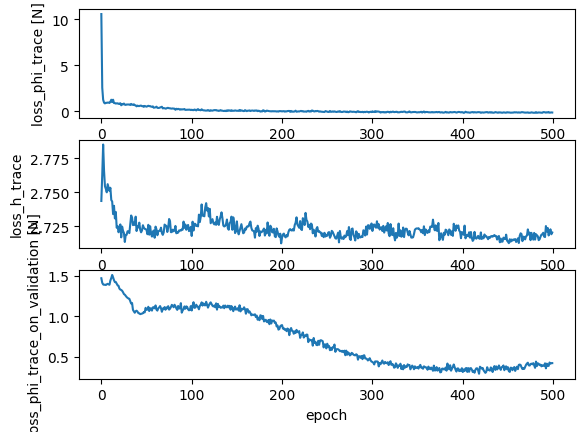

In [2]:
# use the data from previous section to train the model

manager = training_manager.TrainingPipeline()
manager.set_up(
    data_menu=data_list,
    # data_menu=data_list[:4],    # use small data list for quick testing
    input_label_map_file=path1,
    column_map_file=path2,
    can_skip_io_normalizaiton=False,
    can_inspect_data=False,
    validation_data_menu=validation_list[-1:]
)
plt.show() 
manager.train()
manager.trainer_instance.plot_loss()

plt.show()  

Inspect data in the data list.

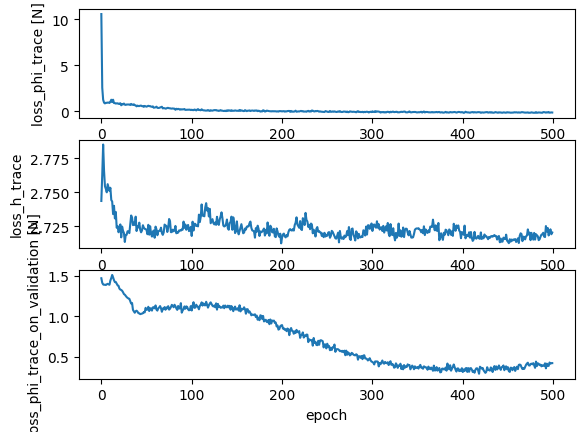

In [3]:
# trainer_instance.inspect_data(data_list[:2])
manager.trainer_instance.plot_loss()

Inspect t-sne of a_trace.

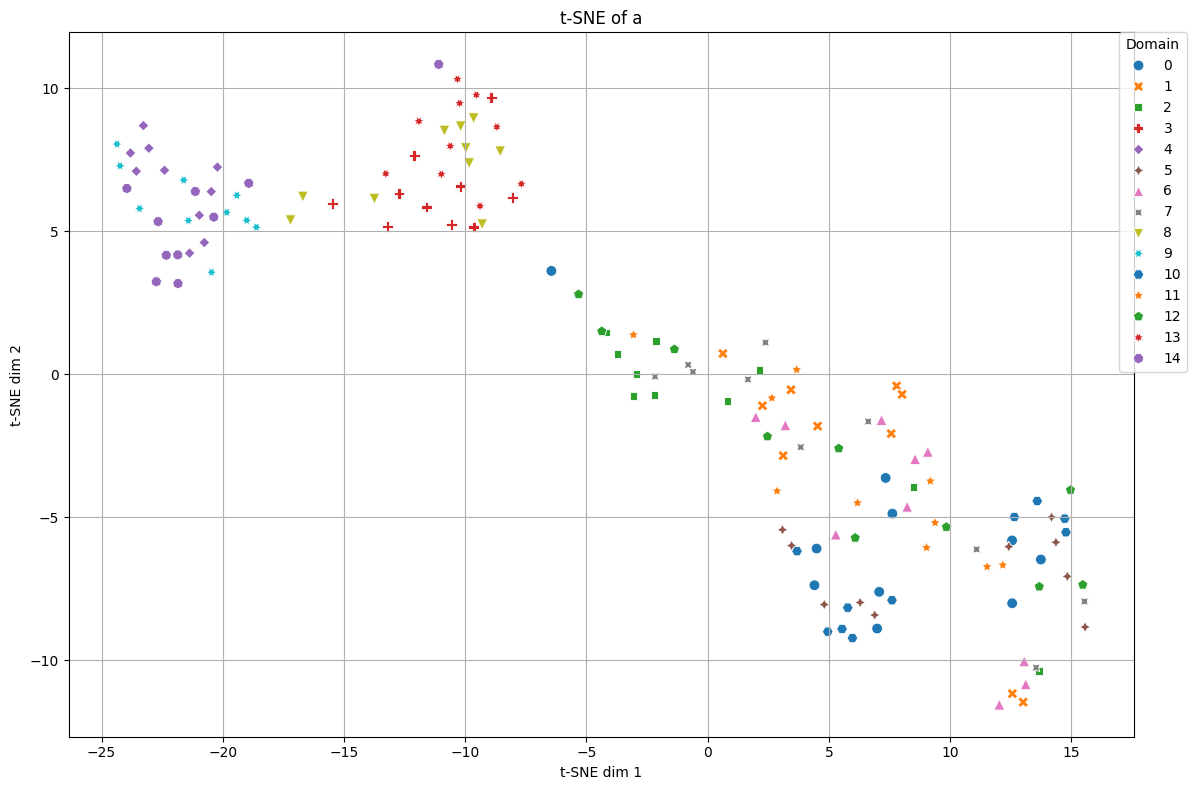

In [4]:
import performance_analyzer
can_print_3d = False
n = 100
performance_analyzer.plot_tsne_of_a(manager.trainer_instance.a_trace, list(range(n, n + 10)))
plt.show()  
if can_print_3d:
    %matplotlib tk
    performance_analyzer.plot_tsne_3d_of_a(manager.trainer_instance.a_trace, list(range(n, n + 10)))


After training, we can save the model in the following way.

In [5]:
model_name = training_subfolder
manager.save_model(model_name)

Model saved to model\wind_near_wall_bemt_in_control_train_xz_wind.pth


Test the model using the test set.

test Data List:
wind_near_wall_validation_bemt\test_wind_near_wall_x0_0_y0_0_z10_0_d0_5_validation_bemt.csv
wind_near_wall_validation_bemt\test_wind_near_wall_x0_0_y0_0_z1_0_d0_5_validation_bemt.csv
wind_near_wall_validation_bemt\test_wind_near_wall_x0_0_y0_0_z4_0_d0_5_validation_bemt.csv
wind_near_wall_validation_bemt\test_wind_near_wall_x0_0_y0_0_zn10_0_d0_5_validation_bemt.csv
wind_near_wall_validation_bemt\test_wind_near_wall_x0_0_y0_0_zn1_0_d0_5_validation_bemt.csv
wind_near_wall_validation_bemt\test_wind_near_wall_x0_0_y0_0_zn4_0_d0_5_validation_bemt.csv
wind_near_wall_validation_bemt\test_wind_near_wall_xn2_0_y0_0_z10_0_d0_5_validation_bemt.csv
wind_near_wall_validation_bemt\test_wind_near_wall_xn2_0_y0_0_z1_0_d0_5_validation_bemt.csv
wind_near_wall_validation_bemt\test_wind_near_wall_xn2_0_y0_0_z4_0_d0_5_validation_bemt.csv
wind_near_wall_validation_bemt\test_wind_near_wall_xn2_0_y0_0_zn10_0_d0_5_validation_bemt.csv
wind_near_wall_validation_bemt\test_wind_near_wall_xn2_0_y0_0_

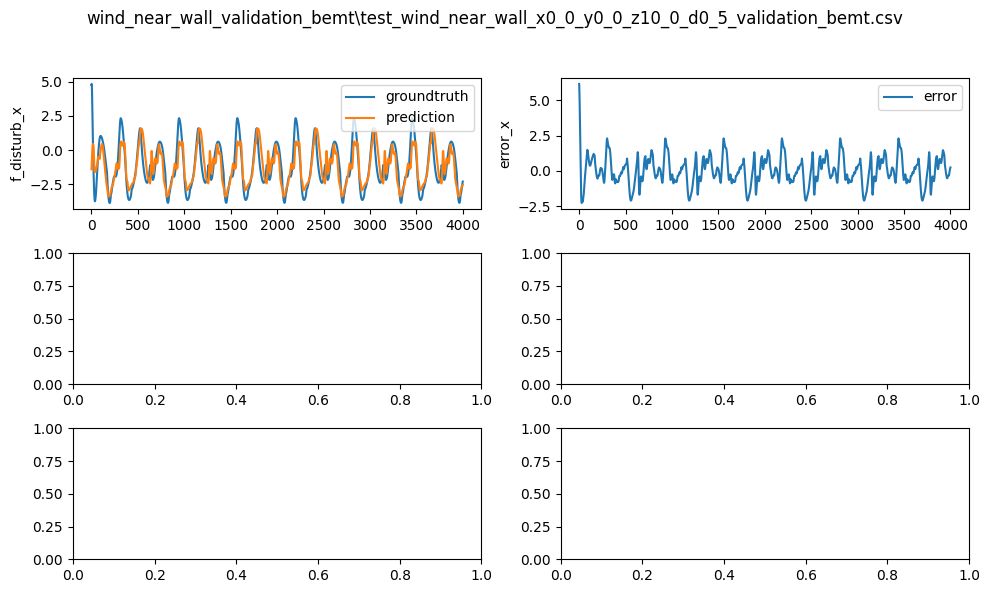

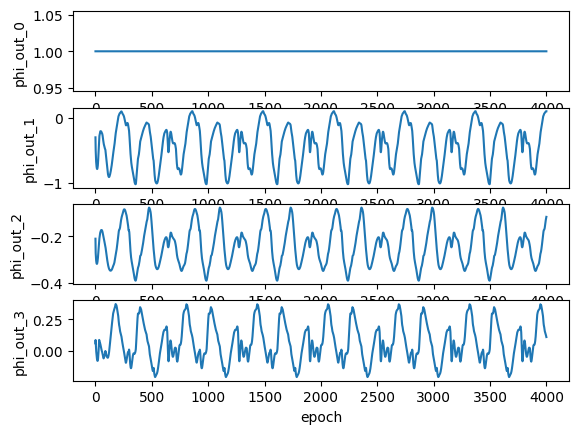

phi_out: tensor([[ 1.0000, -0.2923, -0.2094,  0.0621],
        [ 1.0000, -0.2877, -0.2129,  0.0814],
        [ 1.0000, -0.2914, -0.2149,  0.0847],
        ...,
        [ 1.0000,  0.0520, -0.1148,  0.0959],
        [ 1.0000,  0.0533, -0.1105,  0.0930],
        [ 1.0000,  0.0544, -0.1063,  0.0899]])
a = tensor([[ -1.6515],
        [ -8.6468],
        [  0.2047],
        [-10.7585]])


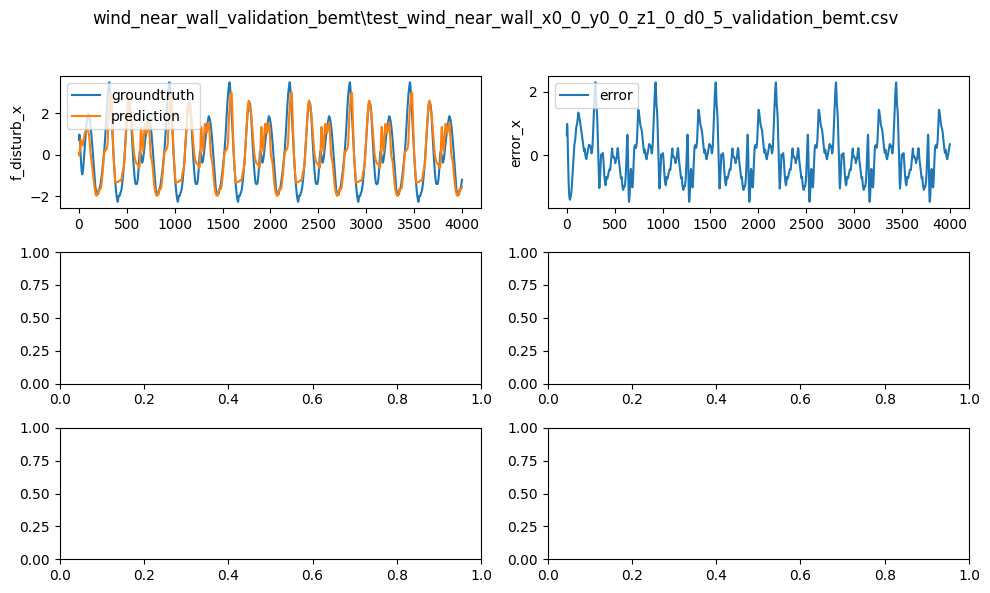

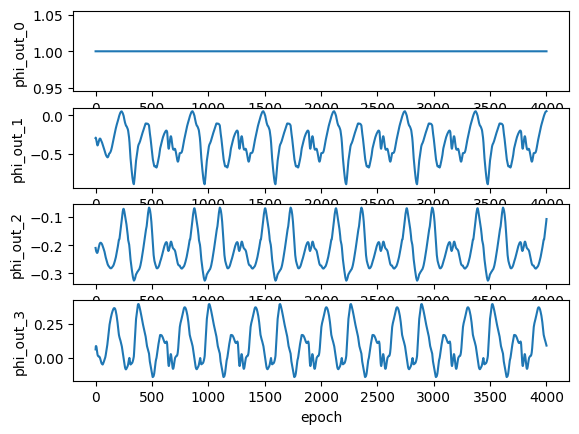

phi_out: tensor([[ 1.0000, -0.2939, -0.2096,  0.0609],
        [ 1.0000, -0.2800, -0.2188,  0.1078],
        [ 1.0000, -0.2868, -0.2221,  0.1141],
        ...,
        [ 1.0000,  0.0673, -0.1302,  0.1073],
        [ 1.0000,  0.0683, -0.1274,  0.1033],
        [ 1.0000,  0.0679, -0.1243,  0.0989]])
a = tensor([[ -2.3124],
        [ -1.1156],
        [-15.6247],
        [-16.8945]])


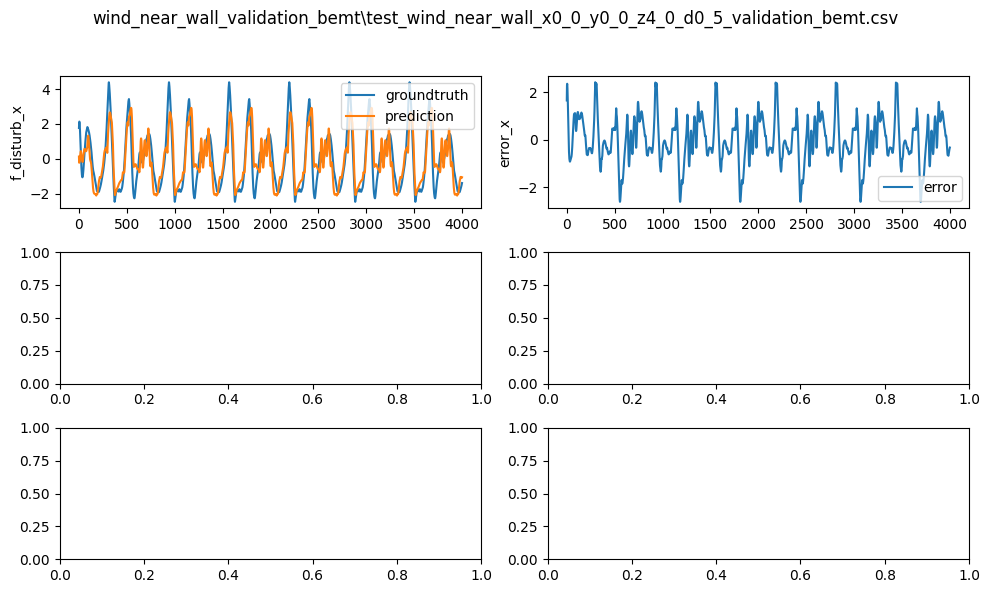

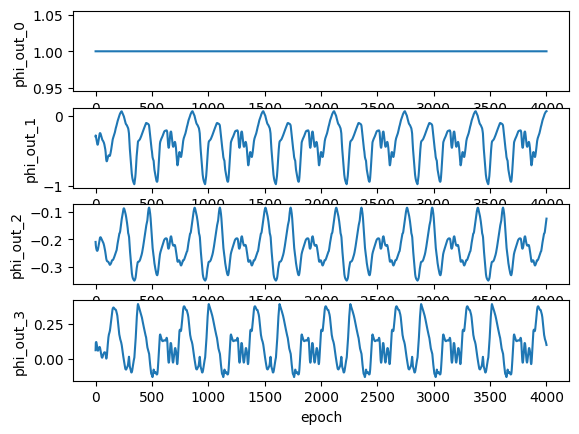

phi_out: tensor([[ 1.0000, -0.2996, -0.2100,  0.0566],
        [ 1.0000, -0.2927, -0.2275,  0.1291],
        [ 1.0000, -0.3079, -0.2337,  0.1409],
        ...,
        [ 1.0000,  0.0235, -0.1761,  0.1250],
        [ 1.0000,  0.0218, -0.1752,  0.1176],
        [ 1.0000,  0.0201, -0.1743,  0.1104]])
a = tensor([[ 1.1189],
        [-6.4063],
        [-9.0137],
        [-7.2921]])


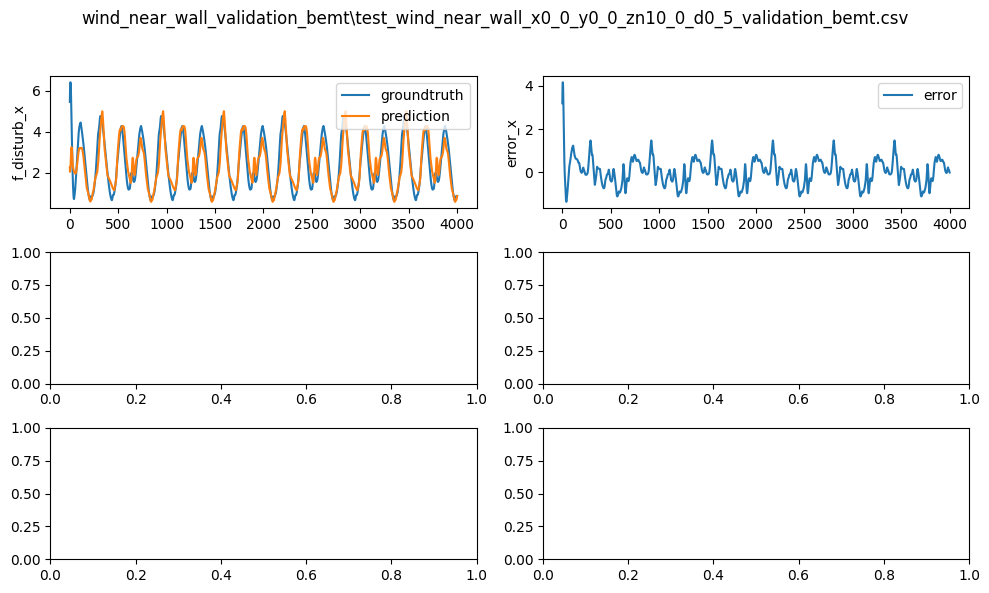

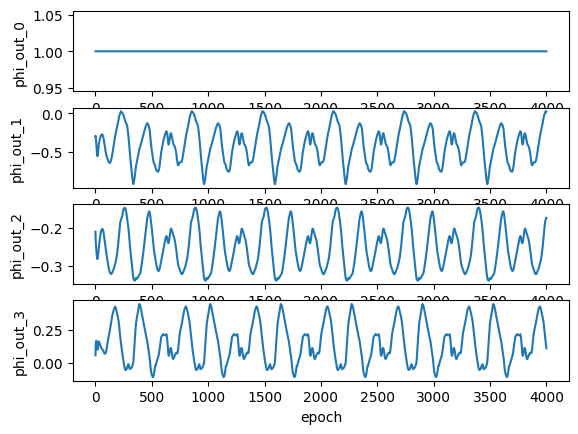

phi_out: tensor([[ 1.0000, -0.2905, -0.2093,  0.0634],
        [ 1.0000, -0.2988, -0.2090,  0.0511],
        [ 1.0000, -0.3012, -0.2097,  0.0515],
        ...,
        [ 1.0000,  0.0508, -0.1127,  0.0977],
        [ 1.0000,  0.0523, -0.1080,  0.0949],
        [ 1.0000,  0.0535, -0.1035,  0.0919]])
a = tensor([[-1.9146],
        [-9.0029],
        [-1.4513],
        [-9.6439]])


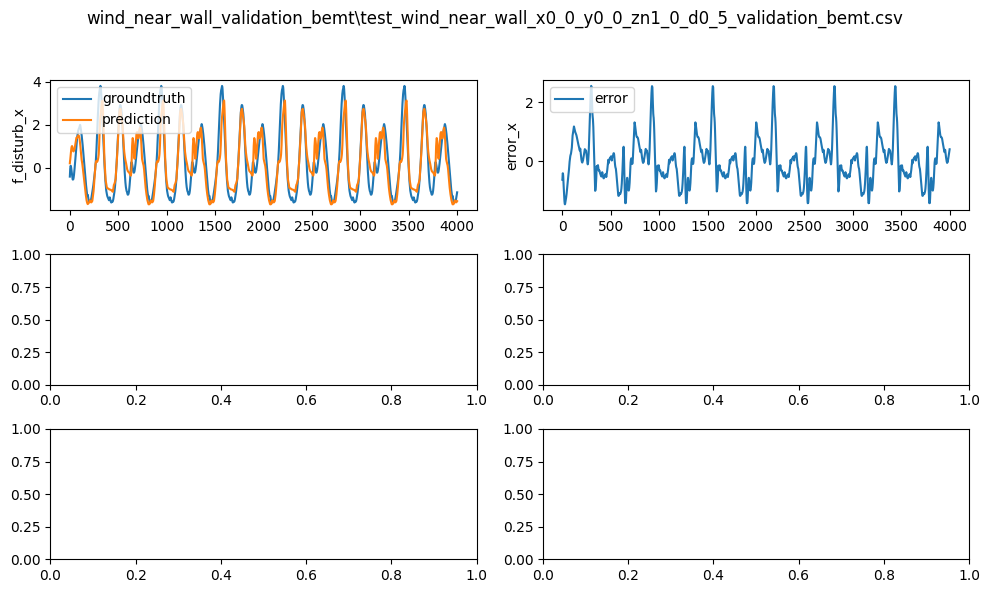

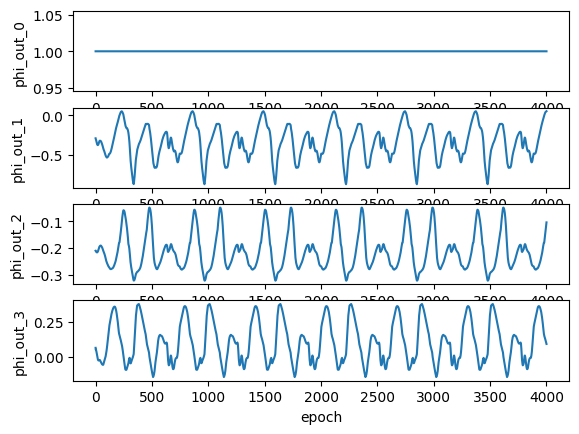

phi_out: tensor([[ 1.0000, -0.2915, -0.2094,  0.0627],
        [ 1.0000, -0.2974, -0.2098,  0.0581],
        [ 1.0000, -0.3003, -0.2110,  0.0605],
        ...,
        [ 1.0000,  0.0500, -0.1300,  0.1006],
        [ 1.0000,  0.0498, -0.1265,  0.0966],
        [ 1.0000,  0.0499, -0.1227,  0.0931]])
a = tensor([[-1.4358e+00],
        [-1.0328e+01],
        [ 7.7045e-03],
        [-6.3495e+00]])


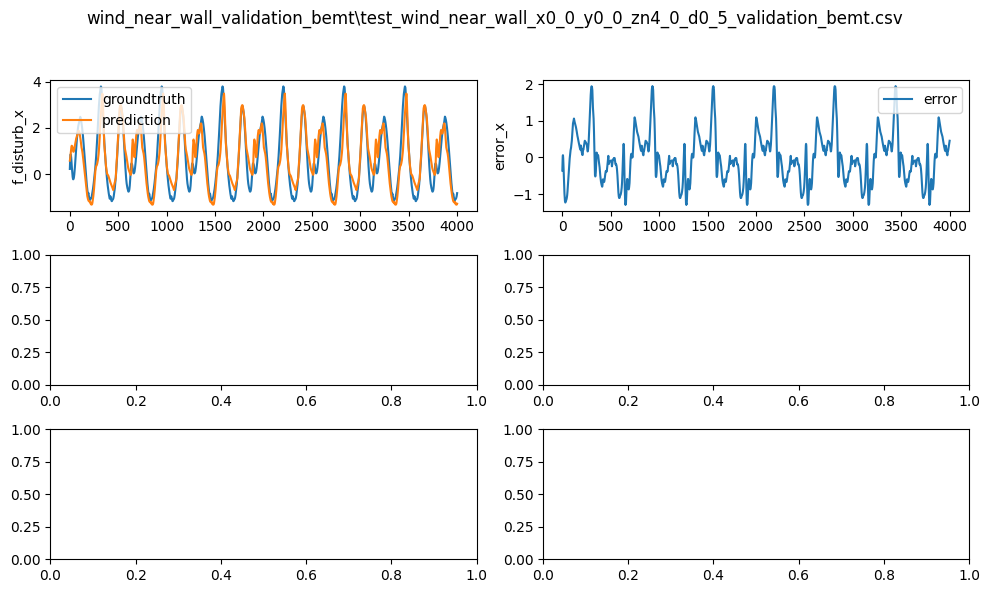

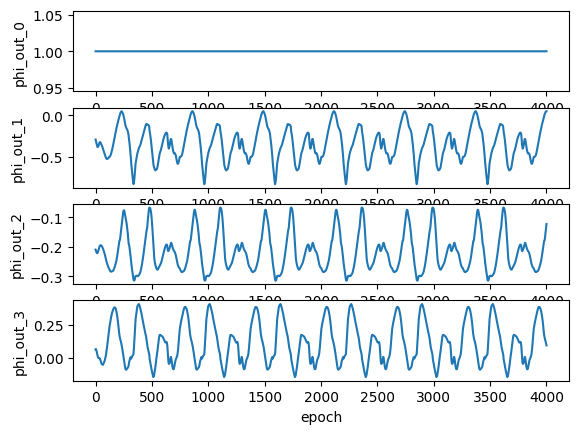

phi_out: tensor([[ 1.0000, -0.2979, -0.2099,  0.0578],
        [ 1.0000, -0.3898, -0.2516,  0.1076],
        [ 1.0000, -0.4598, -0.2634,  0.0782],
        ...,
        [ 1.0000,  0.1051, -0.1209,  0.1146],
        [ 1.0000,  0.1047, -0.1170,  0.1105],
        [ 1.0000,  0.1041, -0.1133,  0.1062]])
a = tensor([[ -3.6916],
        [ -3.6500],
        [ -2.2151],
        [-10.5386]])


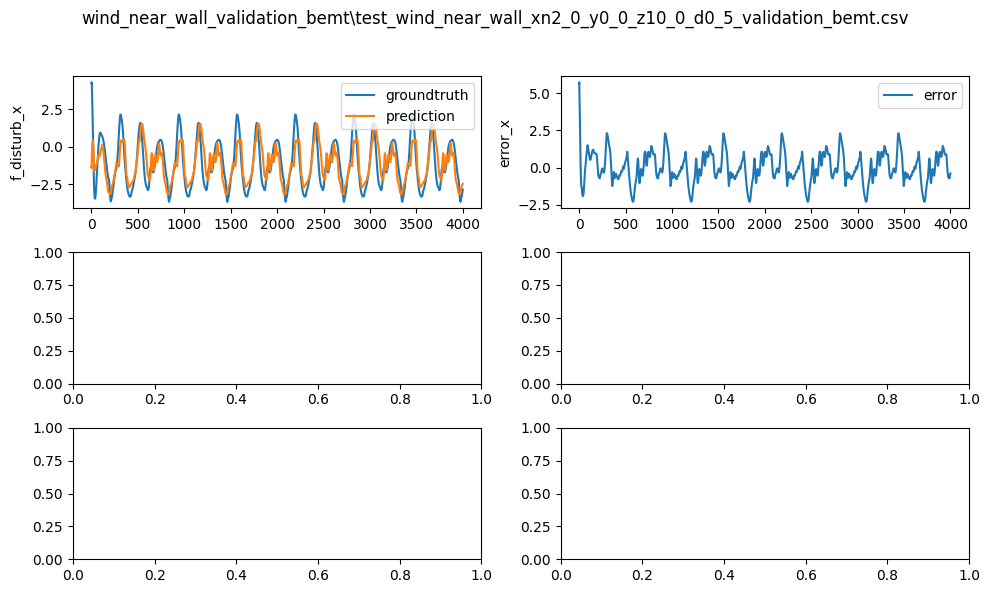

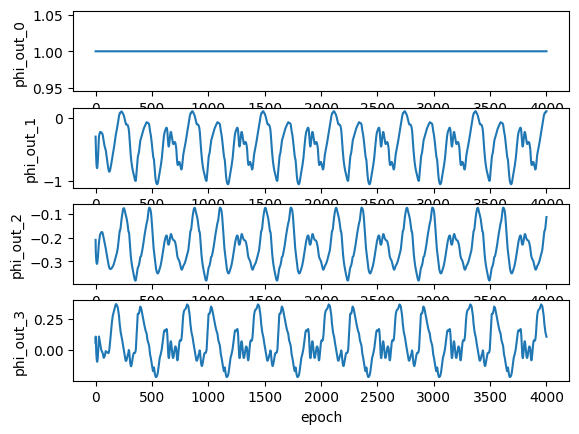

phi_out: tensor([[ 1.0000, -0.2925, -0.2095,  0.0619],
        [ 1.0000, -0.2918, -0.2143,  0.0799],
        [ 1.0000, -0.2996, -0.2172,  0.0806],
        ...,
        [ 1.0000,  0.0514, -0.1237,  0.0956],
        [ 1.0000,  0.0518, -0.1200,  0.0926],
        [ 1.0000,  0.0509, -0.1165,  0.0887]])
a = tensor([[ -1.6719],
        [ -8.8550],
        [  0.7133],
        [-10.1521]])


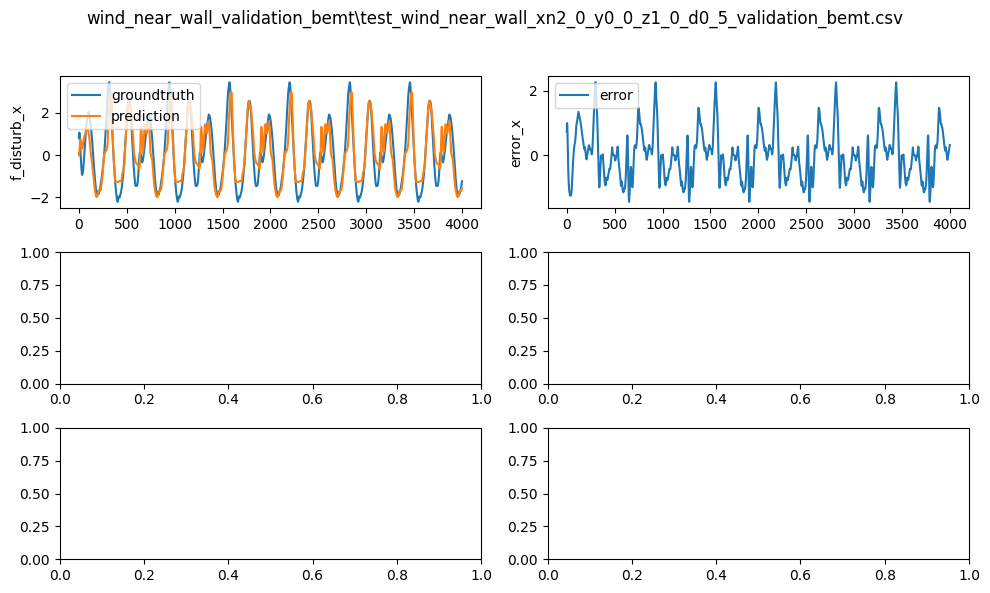

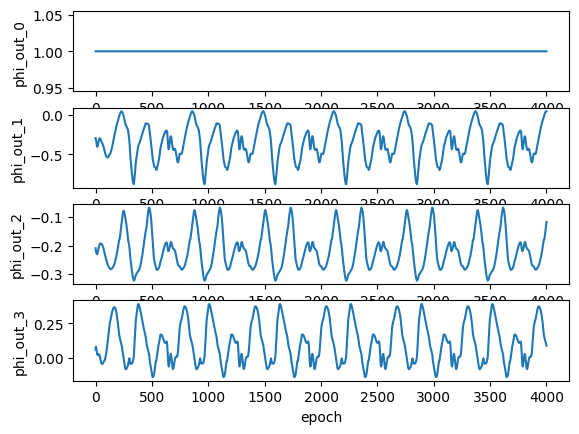

phi_out: tensor([[ 1.0000, -0.2956, -0.2097,  0.0596],
        [ 1.0000, -0.2860, -0.2244,  0.1212],
        [ 1.0000, -0.3004, -0.2295,  0.1258],
        ...,
        [ 1.0000,  0.0561, -0.1352,  0.0981],
        [ 1.0000,  0.0546, -0.1334,  0.0930],
        [ 1.0000,  0.0530, -0.1317,  0.0880]])
a = tensor([[ -1.9554],
        [ -3.1562],
        [ -9.0238],
        [-14.1009]])


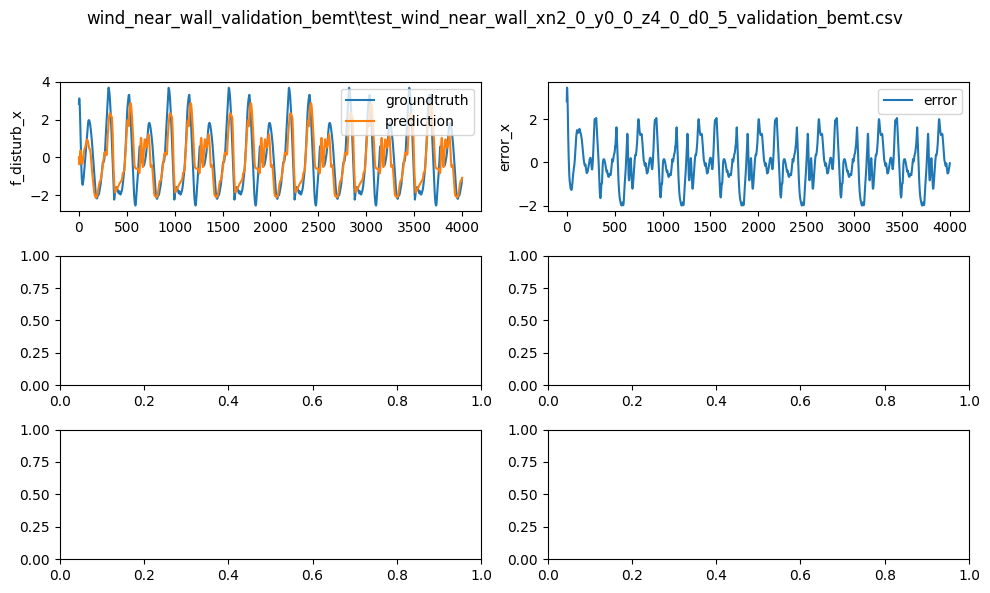

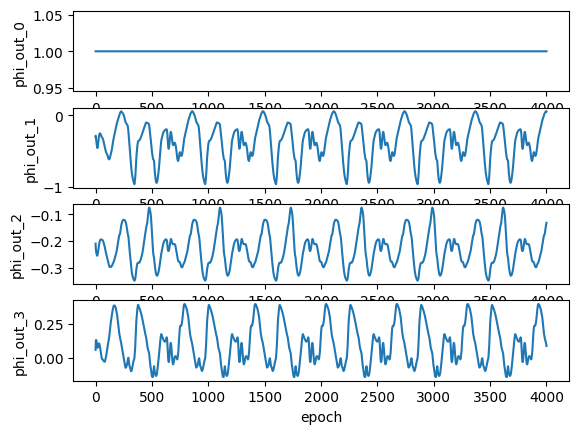

phi_out: tensor([[ 1.0000, -0.2994, -0.2100,  0.0567],
        [ 1.0000, -0.3036, -0.2284,  0.1164],
        [ 1.0000, -0.3258, -0.2350,  0.1231],
        ...,
        [ 1.0000,  0.0102, -0.1772,  0.1171],
        [ 1.0000,  0.0091, -0.1766,  0.1099],
        [ 1.0000,  0.0076, -0.1758,  0.1027]])
a = tensor([[ 1.1076],
        [-6.2896],
        [-9.2279],
        [-7.3406]])


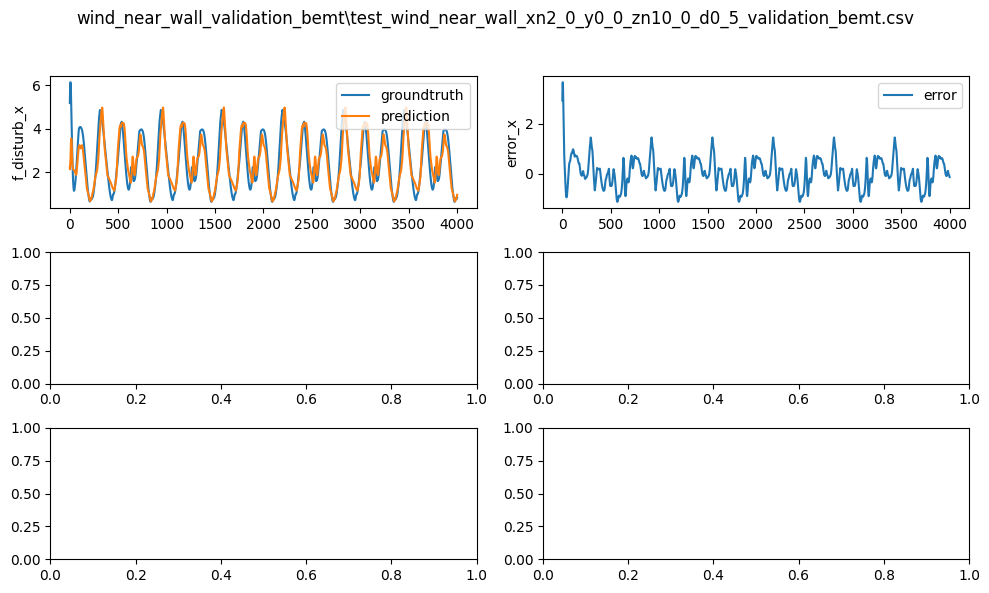

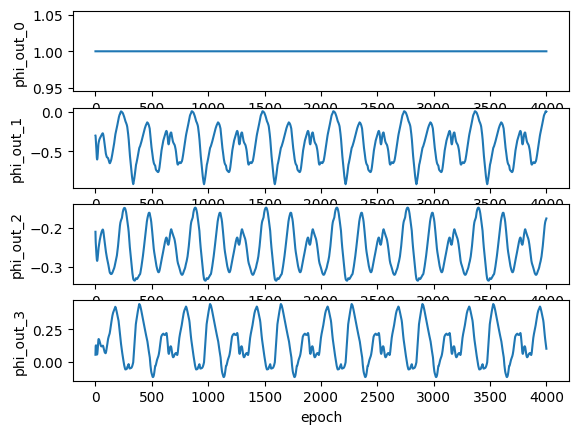

phi_out: tensor([[ 1.0000, -0.2908, -0.2093,  0.0632],
        [ 1.0000, -0.3032, -0.2101,  0.0493],
        [ 1.0000, -0.3102, -0.2118,  0.0466],
        ...,
        [ 1.0000,  0.0455, -0.1153,  0.0957],
        [ 1.0000,  0.0469, -0.1109,  0.0928],
        [ 1.0000,  0.0481, -0.1065,  0.0898]])
a = tensor([[-1.7658],
        [-9.8897],
        [ 1.0140],
        [-8.8196]])


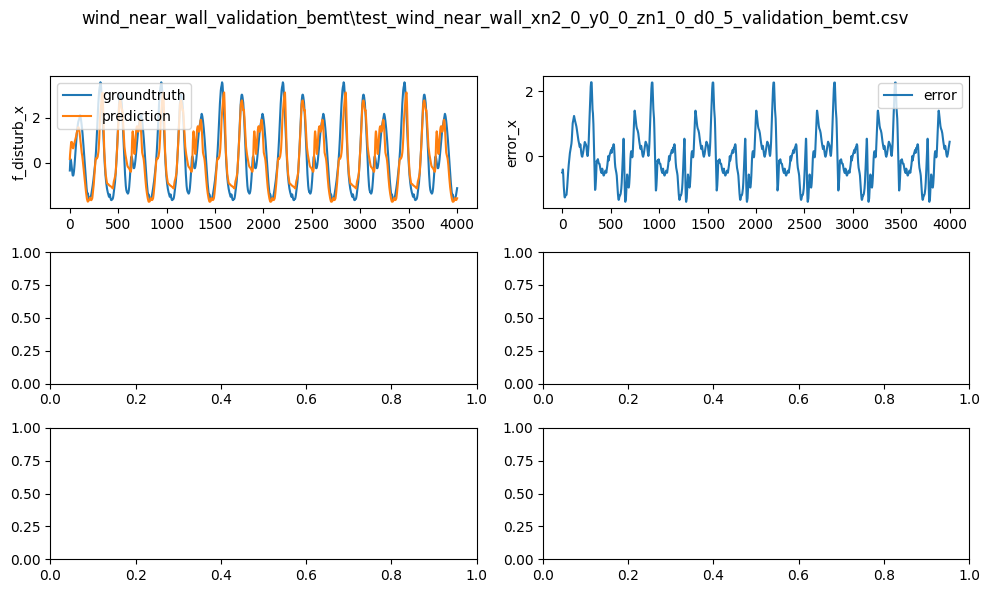

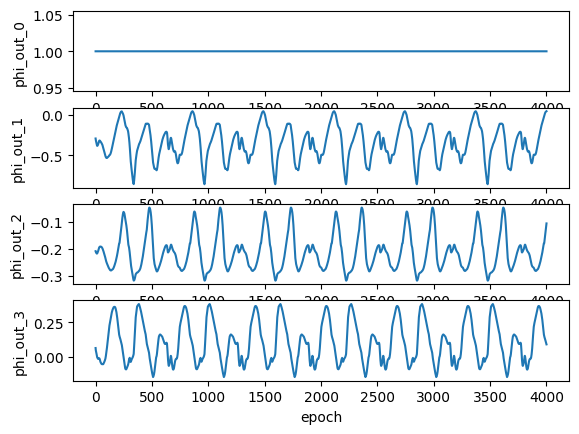

phi_out: tensor([[ 1.0000, -0.2916, -0.2094,  0.0625],
        [ 1.0000, -0.3046, -0.2111,  0.0523],
        [ 1.0000, -0.3135, -0.2134,  0.0504],
        ...,
        [ 1.0000,  0.0414, -0.1286,  0.0967],
        [ 1.0000,  0.0420, -0.1243,  0.0938],
        [ 1.0000,  0.0425, -0.1201,  0.0908]])
a = tensor([[ -1.4229],
        [-10.5384],
        [  0.4122],
        [ -6.3429]])


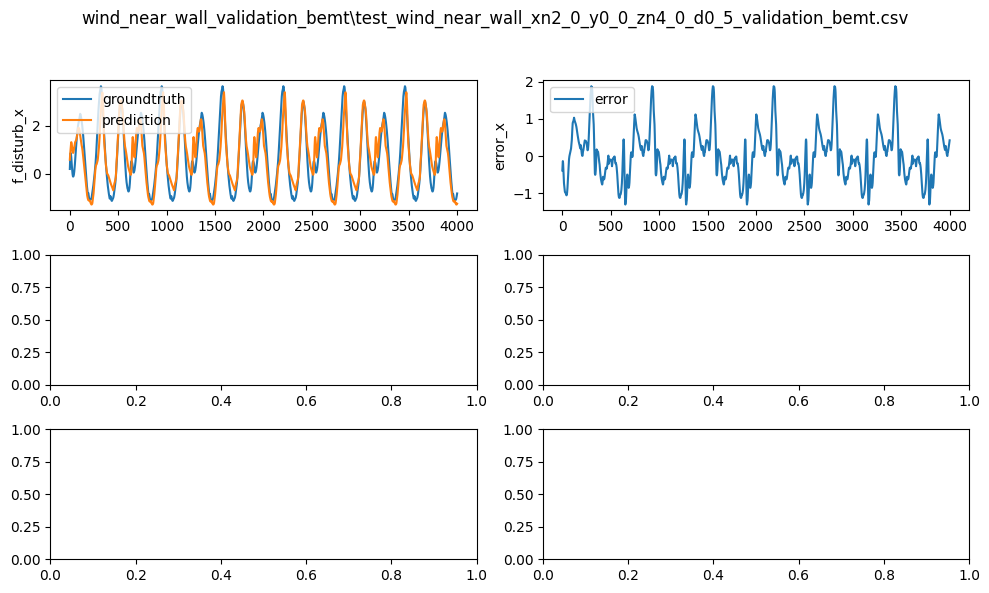

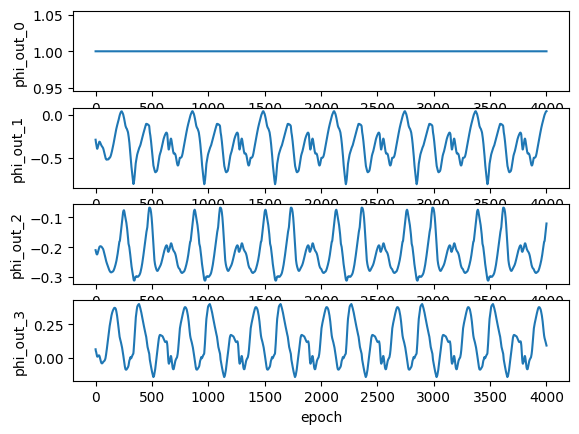

phi_out: tensor([[ 1.0000, -0.2972, -0.2098,  0.0582],
        [ 1.0000, -0.3297, -0.2409,  0.1318],
        [ 1.0000, -0.4170, -0.2531,  0.0885],
        ...,
        [ 1.0000,  0.0762, -0.1587,  0.1259],
        [ 1.0000,  0.0736, -0.1572,  0.1163],
        [ 1.0000,  0.0736, -0.1535,  0.1104]])
a = tensor([[ -4.6451],
        [ -1.0490],
        [-11.1028],
        [-10.8924]])


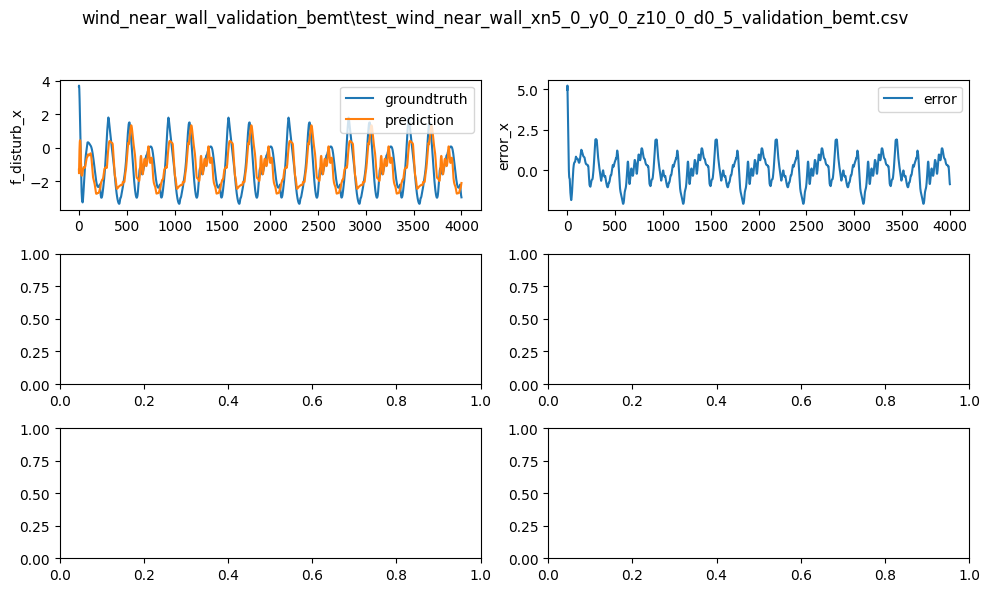

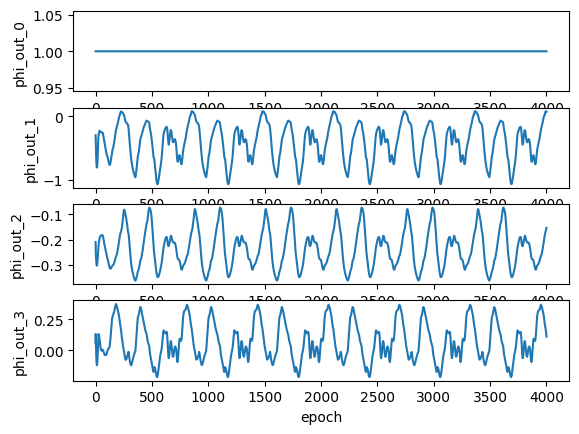

phi_out: tensor([[ 1.0000, -0.2933, -0.2095,  0.0613],
        [ 1.0000, -0.2982, -0.2178,  0.0815],
        [ 1.0000, -0.3116, -0.2213,  0.0796],
        ...,
        [ 1.0000,  0.0467, -0.1359,  0.0975],
        [ 1.0000,  0.0451, -0.1334,  0.0921],
        [ 1.0000,  0.0434, -0.1311,  0.0865]])
a = tensor([[-1.6872],
        [-8.5556],
        [ 0.2996],
        [-9.7331]])


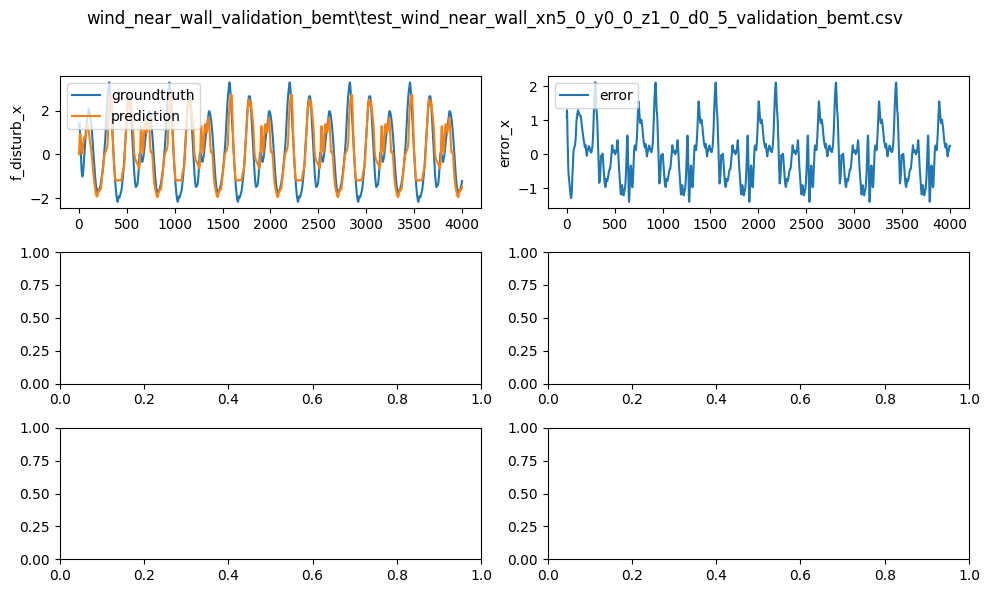

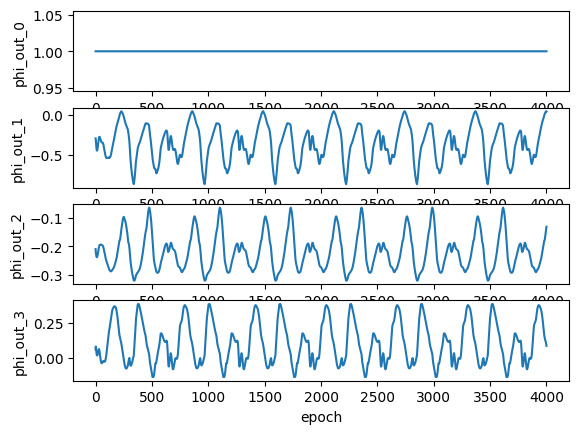

phi_out: tensor([[ 1.0000, -0.2955, -0.2097,  0.0596],
        [ 1.0000, -0.3044, -0.2264,  0.1030],
        [ 1.0000, -0.3363, -0.2318,  0.0944],
        ...,
        [ 1.0000,  0.0412, -0.1670,  0.1165],
        [ 1.0000,  0.0399, -0.1660,  0.1103],
        [ 1.0000,  0.0385, -0.1654,  0.1040]])
a = tensor([[ -2.1728],
        [ -3.3729],
        [ -8.0225],
        [-11.9979]])


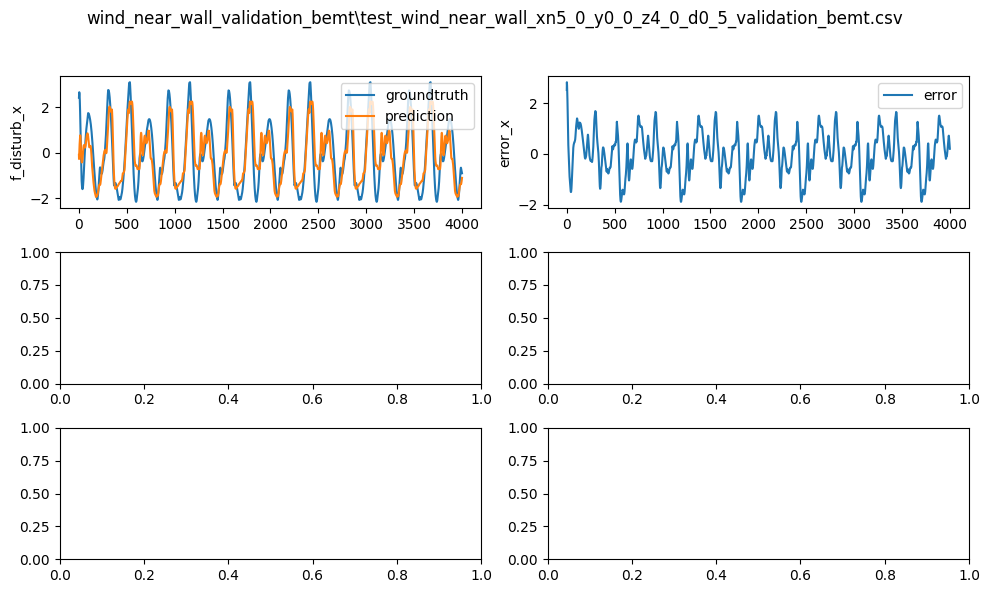

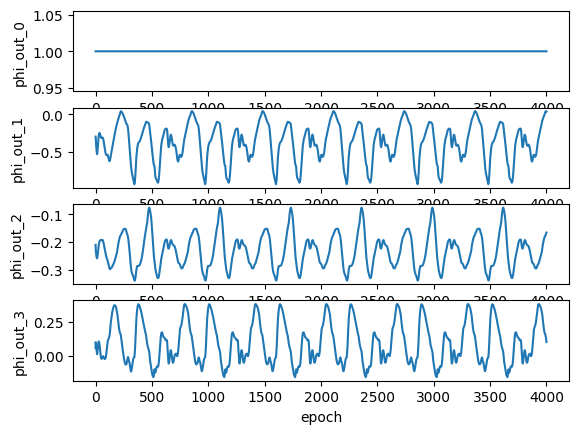

phi_out: tensor([[ 1.0000, -0.2996, -0.2100,  0.0564],
        [ 1.0000, -0.3187, -0.2296,  0.1036],
        [ 1.0000, -0.3613, -0.2377,  0.0966],
        ...,
        [ 1.0000, -0.0065, -0.1784,  0.1050],
        [ 1.0000, -0.0075, -0.1776,  0.0981],
        [ 1.0000, -0.0087, -0.1767,  0.0913]])
a = tensor([[  0.9369],
        [ -5.5246],
        [-11.9564],
        [ -8.3674]])


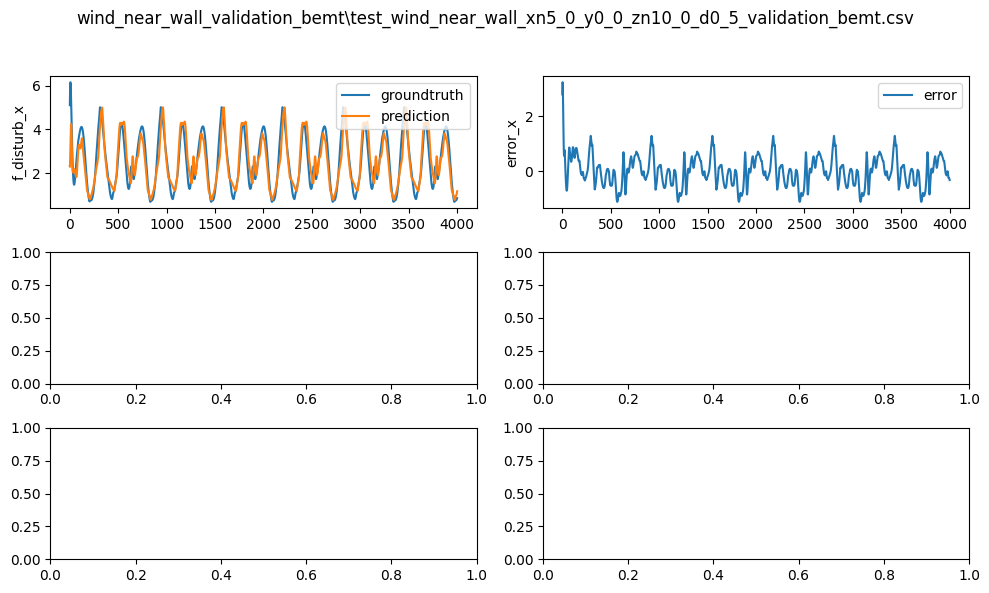

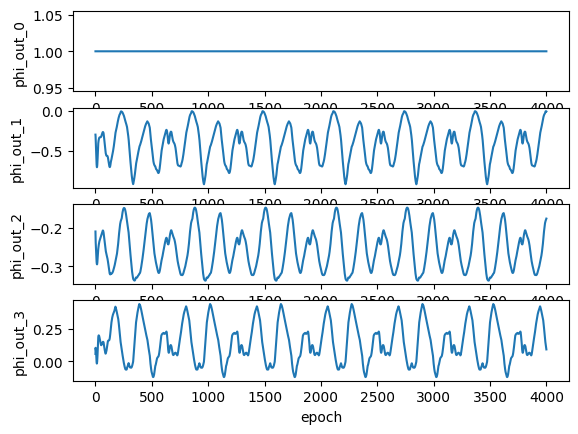

phi_out: tensor([[ 1.0000, -0.2916, -0.2094,  0.0625],
        [ 1.0000, -0.3063, -0.2124,  0.0549],
        [ 1.0000, -0.3193, -0.2152,  0.0498],
        ...,
        [ 1.0000,  0.0409, -0.1347,  0.0958],
        [ 1.0000,  0.0397, -0.1324,  0.0907],
        [ 1.0000,  0.0384, -0.1301,  0.0855]])
a = tensor([[-1.7305],
        [-9.7359],
        [ 0.8089],
        [-8.2349]])


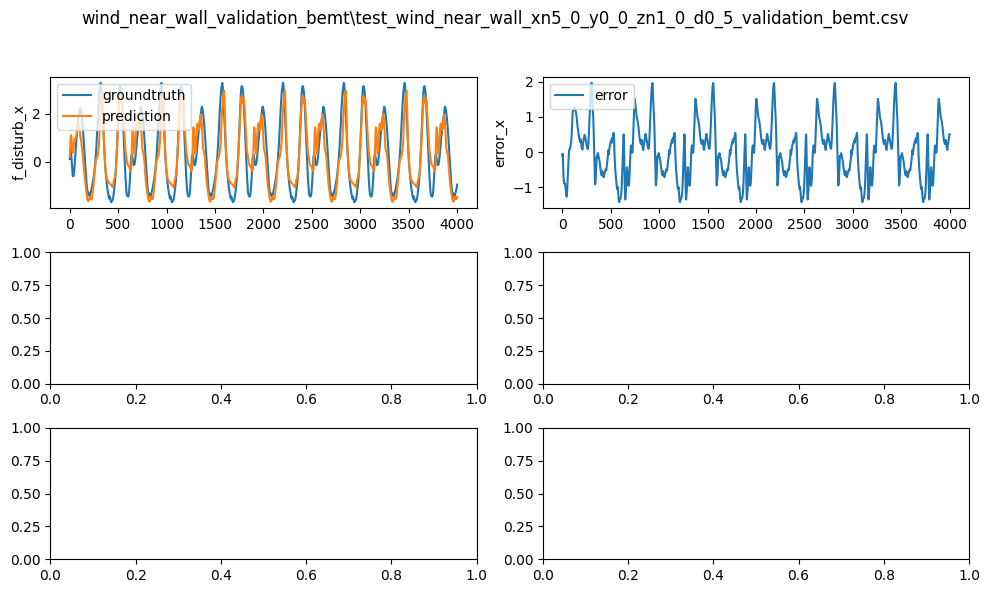

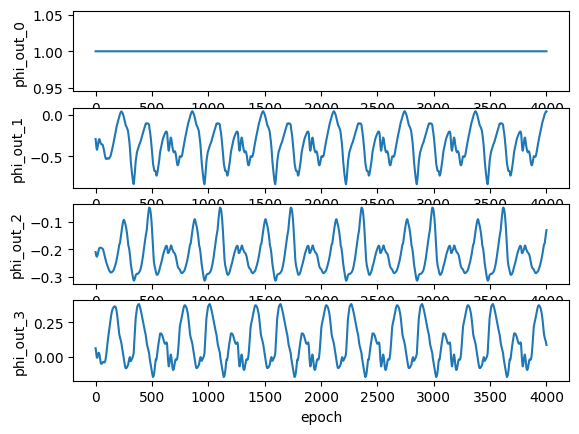

phi_out: tensor([[ 1.0000, -0.2920, -0.2094,  0.0622],
        [ 1.0000, -0.3166, -0.2133,  0.0435],
        [ 1.0000, -0.3319, -0.2154,  0.0372],
        ...,
        [ 1.0000,  0.0317, -0.1317,  0.0939],
        [ 1.0000,  0.0327, -0.1279,  0.0911],
        [ 1.0000,  0.0318, -0.1243,  0.0873]])
a = tensor([[ -1.4257],
        [-10.1755],
        [ -0.9556],
        [ -6.9265]])


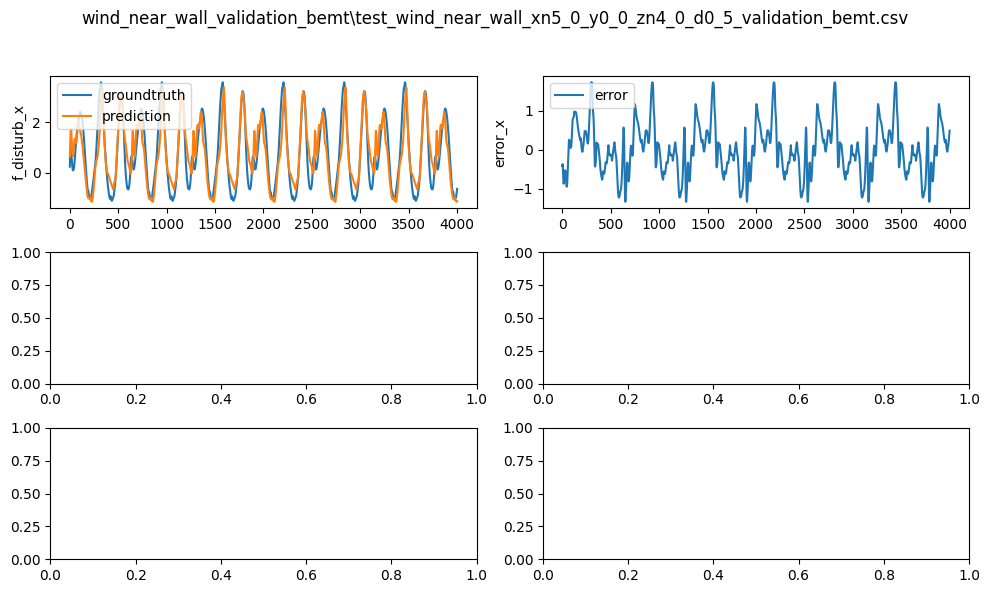

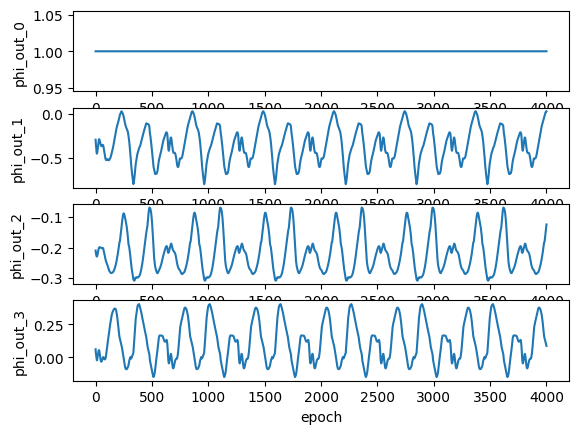

average rms for dim 0: 0.7699687214930504


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:143: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


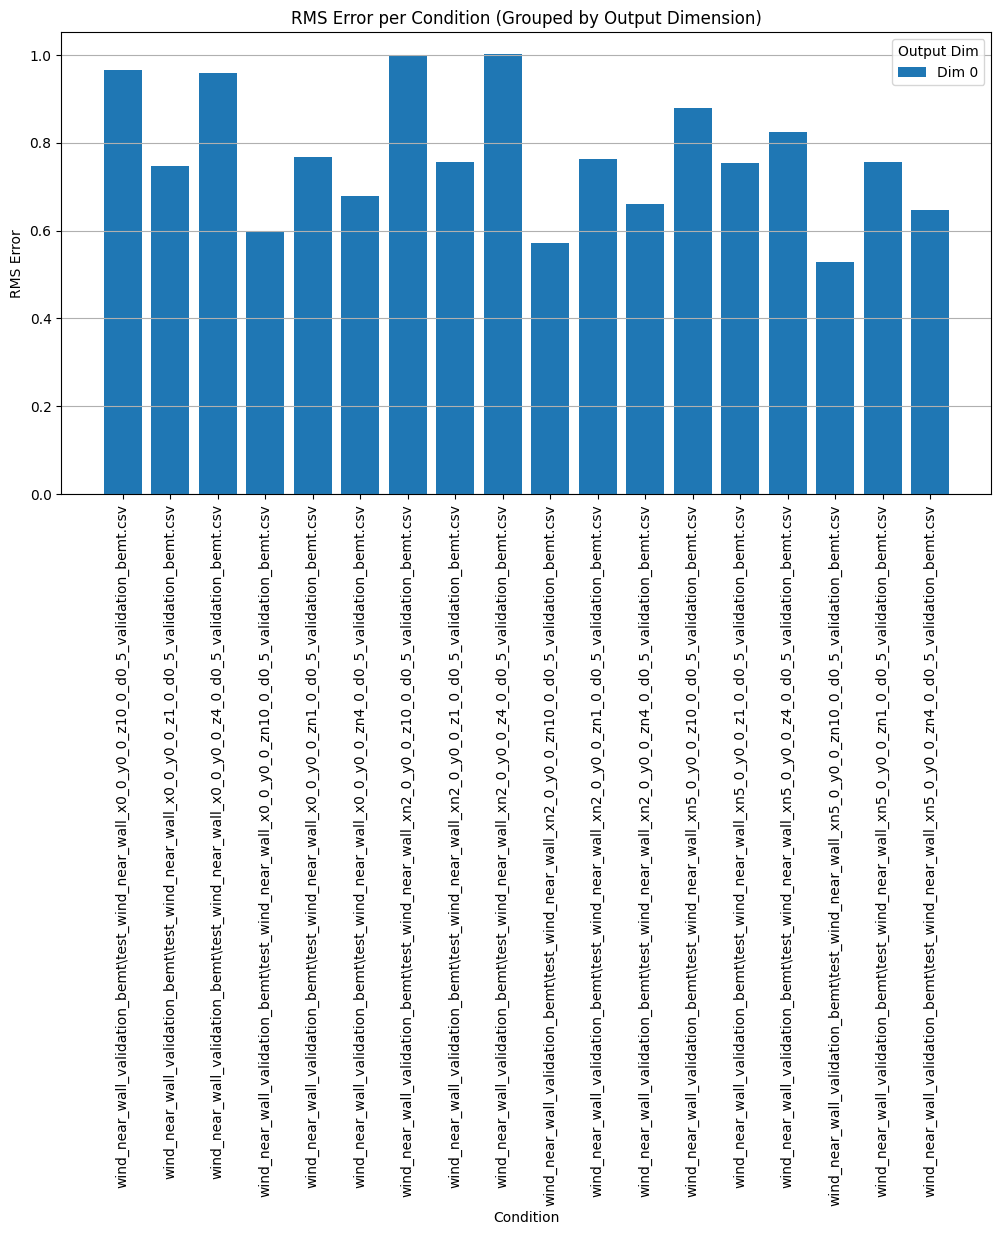

average mse for dim 0: 0.6127358979908961


c:\YimingVirtualDDrive\7_workSpace\repo\neural-fly\Simulation\learning\validator.py:169: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


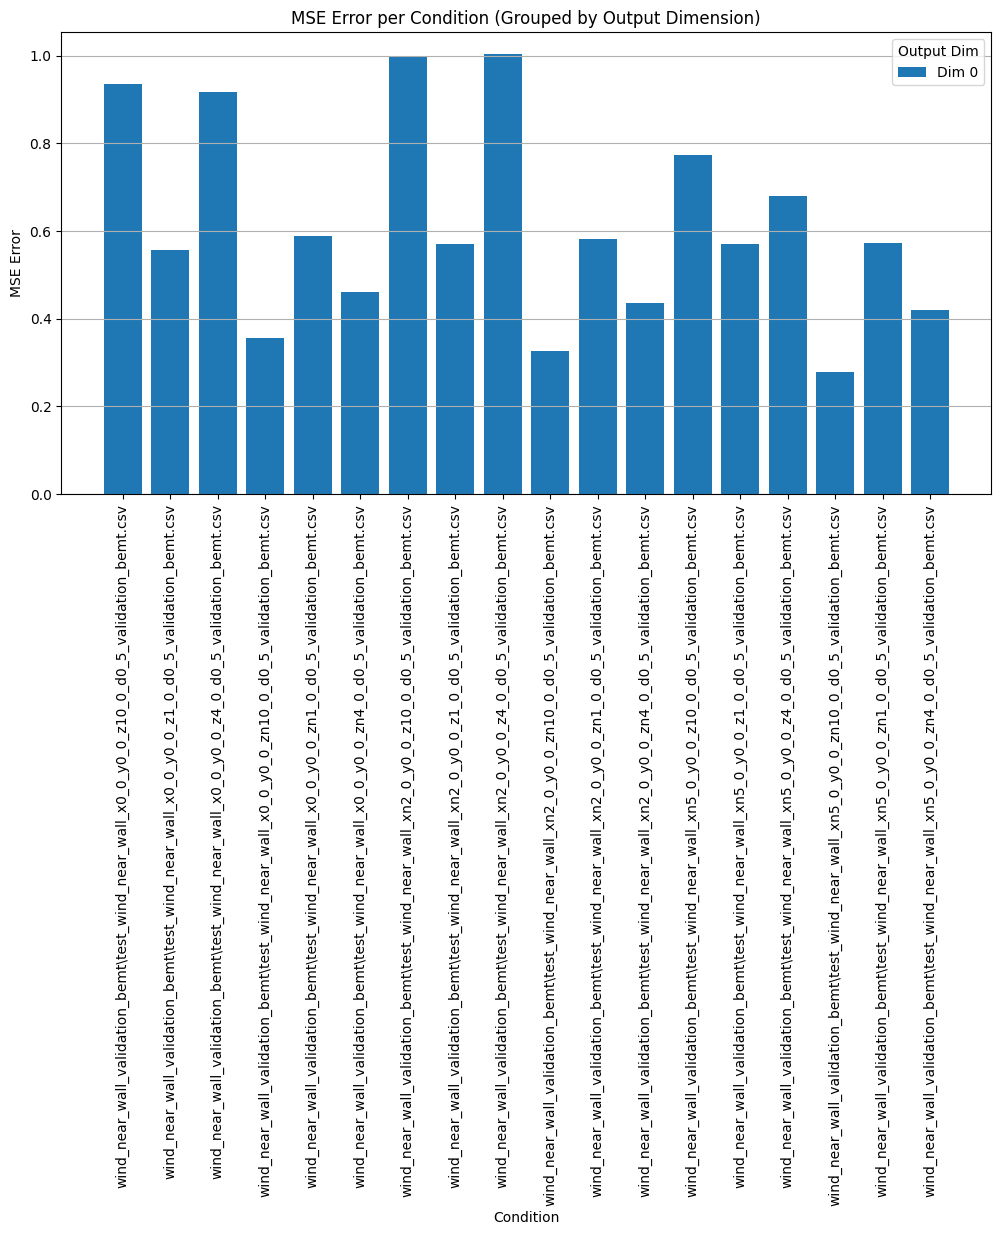

In [6]:
%matplotlib inline
model_name = training_subfolder

subfolder = "wind_near_wall_validation_bemt"
# subfolder = "wind_near_wall_validation_no_bemt"
# subfolder = "nf_validation_back2back"
data_list = generate_data_list(subfolder)
print("test Data List:")
for data in data_list:
    print(data)

# debug
# data_list = data_list[:1]  # use small data list for quick testing

manager = training_manager.TestManager()
manager.set_up(
    data_menu=data_list,
    input_label_map_file=path1,
    column_map_file=path2,
    can_skip_io_normalizaiton=False
)

phi, h = training_manager.load_model(model_name)
# make a new trainer to replicate the above setup, just to allow verify_model to work
manager.test(phi, h, data_list)
plt.show()  
